# Image Segmentation on Skin Cancer


![](https://www.mayoclinic.org/-/media/kcms/gbs/patient-consumer/images/2013/11/15/17/40/ds00190_-ds00439_-ds00924_-ds00925_im02400_c7_skincancerthu_jpg.jpg)

## About Data

[Dataset](https://www.kaggle.com/nodoubttome/skin-cancer9-classesisic)

This set consists of 2357 images of malignant and benign oncological diseases, which were formed from The International Skin Imaging Collaboration (ISIC). 

All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:

- actinic keratosis
- basal cell carcinoma
- dermatofibroma
- melanoma
- nevus
- pigmented benign keratosis
- seborrheic keratosis
- squamous cell carcinoma
- vascular lesion


**Imports**

In [1]:
import os,re,zipfile

# data manipulation packages
import pandas as pd
import numpy as np
from PIL import Image

# data viz
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set_style('whitegrid')


**Download the dataset from Kaggle**

In [2]:
%%time
zip_name = 'skin-cancer9-classesisic.zip'
if not os.path.exists(zip_name):
  os.environ['KAGGLE_USERNAME'] = "" # username from the json file
  os.environ['KAGGLE_KEY'] = "" # key from the json file
  !kaggle datasets download nodoubttome/skin-cancer9-classesisic

CPU times: user 19 µs, sys: 5 µs, total: 24 µs
Wall time: 28.6 µs


**Unzip the dataset**

In [3]:
with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall(zip_name.split('.')[0])

**Paths to Train & Test folders**

In [4]:
train_path = '/content/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
test_path = '/content/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test'

**Create a dataframe with filename, filepath and the disease type**

In [5]:
train = list()
for cls in os.listdir(train_path):
    for filename in os.listdir(os.path.join(train_path,cls)):
        train.append({
            'filename': filename,
            'filepath': os.path.join(train_path,cls,filename),
            'label': cls
        })
train = pd.DataFrame(train)
train[:3]

,filename,filepath,label
0,ISIC_0025915.jpg,/content/skin-cancer9-classesisic/Skin cancer ...,pigmented benign keratosis
1,ISIC_0024947.jpg,/content/skin-cancer9-classesisic/Skin cancer ...,pigmented benign keratosis
2,ISIC_0026539.jpg,/content/skin-cancer9-classesisic/Skin cancer ...,pigmented benign keratosis


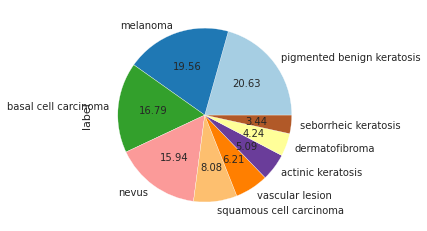

In [6]:
p = (train.label.value_counts() / len(train))
p.plot.pie(cmap='Paired',autopct='%.2f');

## How the image data looks like ?

let's pick a sample image of melanoma

In [7]:
img_name, img_path, img_label = train[train.label == 'melanoma'][4:5].values.ravel()

now we want to load the image using the `pillow` package

In [8]:
img = Image.open(img_path)

then we want to convert the image object into a numpy array

In [9]:
img_arr = np.array(img)

finally we want to print our image

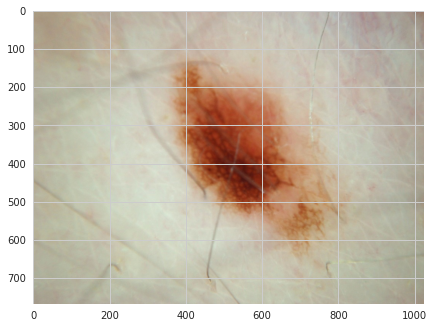

In [10]:
plt.figure(figsize=(7,7))
plt.imshow(img_arr);

**Image as data**

A RGB image has 3 color channels as the RGB (Red, Green, Blue). Those 3 channels are 3 different matrices of with pixel values inside, and overlaying them we can get a normal image as we know.


![](https://media.geeksforgeeks.org/wp-content/uploads/Pixel.jpg)

let's try to extract and see the image through each one of this channels

In [11]:
img_arr.shape

(768, 1024, 3)

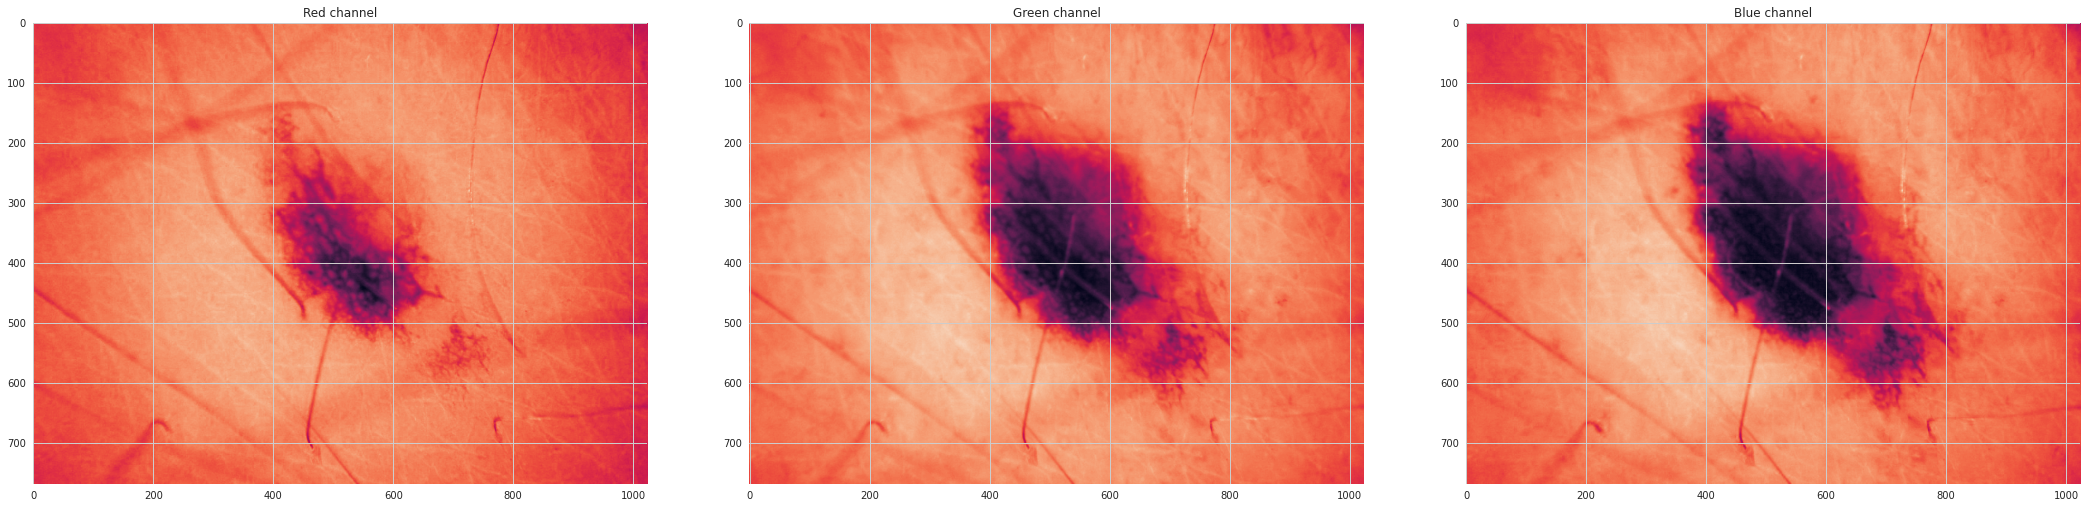

In [12]:
fig,(ax1, ax2, ax3) = plt.subplots(1,3,figsize=(30,7))

# red channel
ax1.imshow(img_arr[:,:,0])
ax1.set_title('Red channel')

# green channel
ax2.imshow(img_arr[:,:,1])
ax2.set_title('Green channel')

# blue channel
ax3.imshow(img_arr[:,:,2])
ax3.set_title('Blue channel')

plt.tight_layout()

here we can see that the clearest image of the melanoma is on the blue channel, for segmenting the melanoma from this image we want to convert the image into black and white

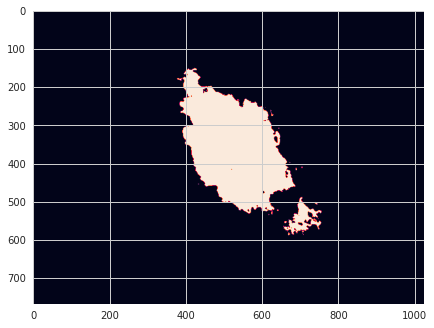

In [13]:
plt.figure(figsize=(7,7))
threshold = 85 # threshold for the binary mask
max_val = 255 # biggest value for pixel

# create a binary mask where values greater than threshold -> True & False mask * 255 will create 0 and 255 pixels
img_bin = (img_arr[:,:,2] < threshold) * max_val

plt.imshow(img_bin);

In [14]:
import cv2
from skimage import segmentation

## Erosion

For an erosion, you examine all of the pixels in a pixel neighbourhood that are touching the structuring element. If every non-zero pixel is touching a structuring element pixel that is 1, then the output pixel in the corresponding centre position with respect to the input is 1. If there is at least one non-zero pixel that does not touch a structuring pixel that is 1, then the output is 0.

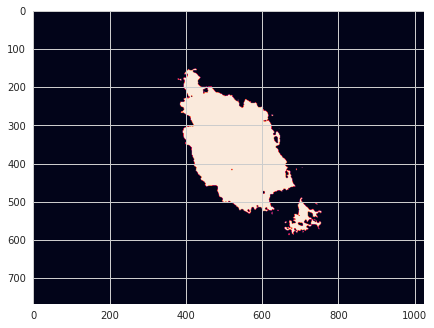

In [15]:
plt.figure(figsize=(7,7))
kernel = np.ones((2,2),np.uint8)
erosion = cv2.erode(img_bin.astype(np.uint8),kernel,iterations = 1)
plt.imshow(erosion);

## Dilation

Dilation is the opposite of erosion. If there is at least one non-zero pixel that touches a pixel in the structuring element that is 1, then the output is 1, else the output is 0. You can think of this as slightly enlarging object areas and making small islands bigger.


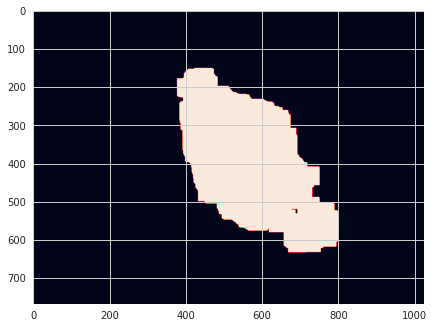

In [16]:
plt.figure(figsize=(7,7))
kernel = np.ones((2,2),np.uint8)
dilation = cv2.dilate(img_bin.astype(np.uint8),kernel,iterations = 45)
plt.imshow(dilation);

**Results**

Here we can see how we can highlight the mask for the cancer spots

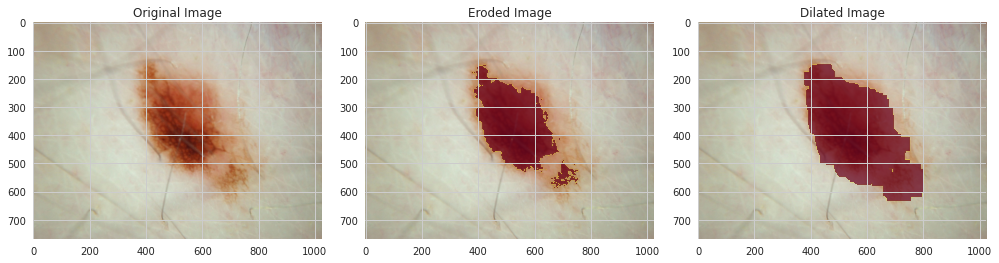

In [17]:
fig,(ax1, ax2, ax3) = plt.subplots(1,3,figsize=(14,7))

ax1.imshow(img_arr);

# draw contour around the mask
ax2.imshow(segmentation.mark_boundaries(img_arr, np.ma.masked_where(erosion == 0, erosion)));

# we reverse the pixels and show the eroded mask over the original image
ax2.imshow(np.ma.masked_where(erosion == 0, erosion),'RdBu', alpha=0.7, interpolation='none')


# draw contour around the mask
ax3.imshow(segmentation.mark_boundaries(img_arr, np.ma.masked_where(dilation == 0, dilation)));
# we reverse the pixels and show the dilated mask over the original image
ax3.imshow(np.ma.masked_where(dilation == 0, dilation),'RdBu', alpha=0.7, interpolation='none')


ax1.set_title('Original Image')
ax2.set_title('Eroded Image')
ax3.set_title('Dilated Image')

plt.tight_layout();